# Figure 4

## Imports

In [11]:
import matplotlib.pyplot as plt
import numpy
import os
import copy
import shutil

import dolfin_mech                    as dmech

## Creating folder for temporary files

In [12]:
current_directory=os.getcwd()
new_directory="calc_fig4"
res_basename = os.path.join(current_directory, new_directory)

try:
    shutil.rmtree(res_basename)
except OSError:
    pass

os.mkdir(res_basename)

clean_upon_completion=True

## Parameters

### Mesh

In [13]:
cube_params = {"path_and_mesh_name" : str(current_directory)+"/Meshes/generic_lung.xdmf", "refine": True} ### the mesh is refined only for plotting purposes

### Material

In [14]:
params = {
        "alpha": 0.16, ### kPa
        "gamma":0.5, ### [-]
        "c1":1.2, ### kPa
        "c2":0., ## kPa, but obsolete parameter
        "kappa":1e2,  ### kPa
        "eta":1e-5,   ### [-]
        "rho_solid":1e-6} ### g/mm3

mat_params = {"scaling":"linear", "parameters":params}

### Loading

In [15]:
pe, pi = -0.5, -2. # kPa

g = 9.81e3 # mm/s2

## Computing porosity distributions

In [16]:
gravity_lst = [0, 1]
for gravity_ in gravity_lst:

    load_params_inverse = {
        "type":"p_boundary_condition0", "f":gravity_*g, "P0":float(pe)}
    load_params_direct_exhalation = {
        "type":"p_boundary_condition", "f":gravity_*g, "P0":float(pe)}
    load_params_direct_inhalation = {
        "type":"p_boundary_condition", "f":gravity_*g, "P0":float(pi)}
    
    ### computing the unloaded configuration
    Uref, phisref_computation, dVexpiini = dmech.run_RivlinCube_PoroHyperelasticity(
        inverse=1,
        mat_params=mat_params,
        load_params=load_params_inverse,
        get_results=1,
        inertia_params={"applied":True, "rho_val":1e-8},
        step_params={"dt_min":1e-4, "dt_ini":1},
        res_basename=res_basename+"/reference",
        cube_params=cube_params,
        verbose=1)

    ### computing the end-exhalation configuration
    phisref_imposed = [numpy.random.uniform(low=0.4, high=0.6) for i in range(len(phisref_computation))]
    if (gravity_ == 0): # MG: What is the difference between both?
        Uexhal, phisexhal_g0, dVunloaded = dmech.run_RivlinCube_PoroHyperelasticity(
                porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
                mat_params=mat_params,
                load_params=load_params_direct_exhalation,
                res_basename=res_basename+"/exhalation",
                get_results=1,
                inertia_params={"applied":True, "rho_val":1e-8},
                step_params={"dt_min":1e-4, "dt_ini":0.125},
                cube_params=cube_params,
                move_params = {"move":True, "U":Uref},
                verbose=1)
    else:
        Uexhal, phisexhal_g, dVunloaded = dmech.run_RivlinCube_PoroHyperelasticity(
                porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
                mat_params=mat_params,
                load_params=load_params_direct_exhalation,
                res_basename = res_basename+"/exhalation",
                get_results=1,
                inertia_params={"applied":True, "rho_val":1e-8},
                step_params={"dt_min":1e-4, "dt_ini":0.125},
                cube_params=cube_params,
                move_params = {"move":True, "U":Uref},
                verbose=1)

    ### computing the end-inhalation configuration
    Uinhal, phisinhal, dVunloaded = dmech.run_RivlinCube_PoroHyperelasticity(
            porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
            mat_params=mat_params,
            load_params=load_params_direct_inhalation,
            res_basename = res_basename+"/inhalation",
            move_params = {"move":True, "U":Uref},
            get_results=1,
            inertia_params={"applied":True, "rho_val":1e-8},
            step_params={"dt_min":1e-4, "dt_ini":0.125},
            cube_params=cube_params,
            verbose=1)

    if (gravity_ == 0):
        phisinhal_g0 = copy.deepcopy(phisinhal)

In [ ]:
if clean_upon_completion:
    shutil.rmtree(res_basename, ignore_errors=1)

In [ ]:
porosity_lst = numpy.linspace(0, 1, 300)

porosity_exhal_g0 = []
porosity_inhal_g0 = []
porosity_exhal_g  = []
porosity_inhal_g  = []
porosity_ref      = []
porosity_plot     = []
for c in range(0, len(porosity_lst)-1):
    min = porosity_lst[c]
    max = porosity_lst[c+1]
    porosity_exhal_g0.append(numpy.sum([min<=i<max for i in phisexhal_g0]))
    porosity_inhal_g0.append(numpy.sum([min<=i<max for i in phisinhal_g0]))
    porosity_exhal_g.append(numpy.sum([min<=i<max for i in phisexhal_g]))
    porosity_inhal_g.append(numpy.sum([min<=i<max for i in phisinhal]))
    porosity_ref.append(numpy.sum([min<=i<max for i in phisref_imposed]))
    porosity_plot.append(1-(min+(max-min)/2))

## Generating plots

### End-exhalation

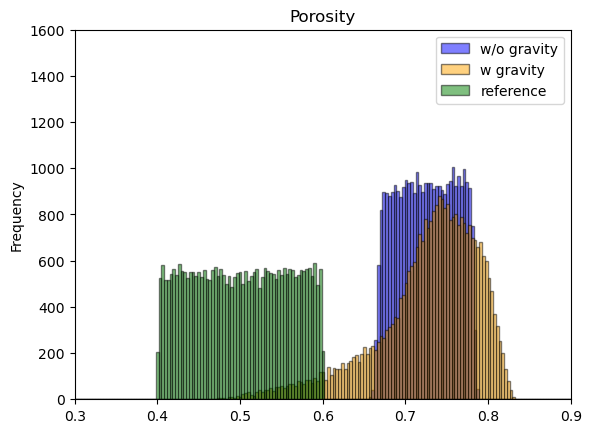

In [ ]:
fig, ax = plt.subplots()
width=max-min
ax.bar(porosity_plot, porosity_exhal_g0, color="blue", label="w/o gravity", alpha=0.5, edgecolor="black", width=width)
ax.bar(porosity_plot, porosity_exhal_g, color="orange", label="w gravity", alpha=0.5, edgecolor="black", width=width)
ax.bar(porosity_plot, porosity_ref, color="green", label="reference", alpha=0.5, edgecolor="black", width=width)
ax.set_ylabel("Frequency")
ax.set_title("Porosity")
ax.legend()
plt.xlim([0.3, 0.9])
plt.ylim([0., 1600])
plt.show()

### End-inhalation

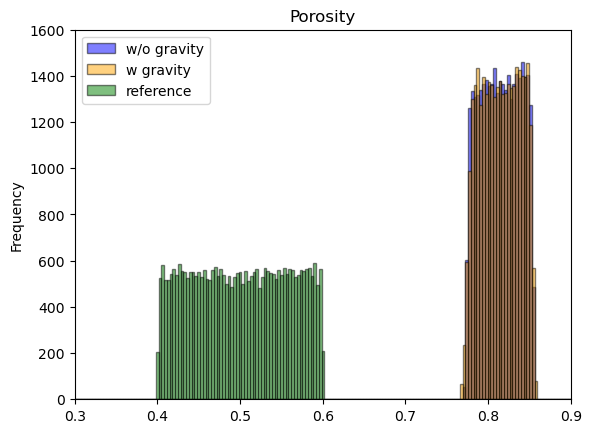

In [ ]:
fig, ax = plt.subplots()
width=max-min
ax.bar(porosity_plot, porosity_inhal_g0, color="blue", label="w/o gravity", alpha=0.5, edgecolor="black", width=width)
ax.bar(porosity_plot, porosity_inhal_g, color="orange", label="w gravity", alpha=0.5, edgecolor="black", width=width)
ax.bar(porosity_plot, porosity_ref, color="green", label="reference", alpha=0.5, edgecolor="black", width=width)
ax.set_ylabel("Frequency")
ax.set_title("Porosity")
ax.legend()
plt.xlim([0.3, 0.9])
plt.ylim([0., 1600])
plt.show()